## **Sentiment Analysis of President Donald Trump's speeches in his second term**

By Syed Faizan 

I used **Huggingfaces BERT based model distilbert-base-uncased-finetuned-sst-2-english** to analyze Trump's speeches for **positive, negative, and neutral sentiment**.

## PLEASE NOTE
**Since the Sentiment analysis using BERT required a GPU to process the more than 23,000 words of the Trump speeches, the code, as a google colab notebook, has been provided in this separate notebook. This separation was necessitated by the need to deploy a google colab A100 GPU for the transformer to function.** 


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Dataset loaded successfully.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentiment Distribution: {'Positive': 2921, 'Negative': 1923, 'Neutral': 0}


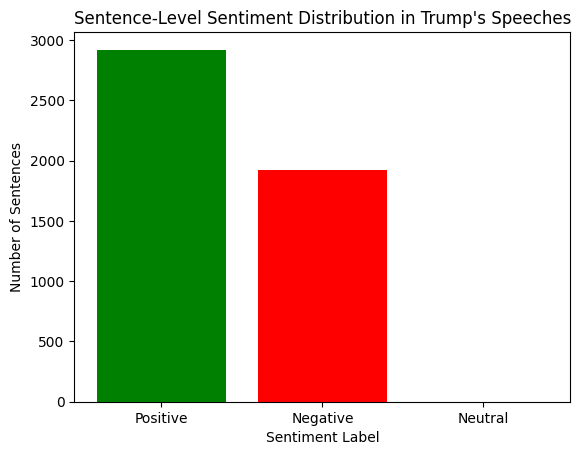

In [2]:
# Load the dataset "Trump_addresses.csv"
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer

nltk.download('punkt_tab')


# Load the dataset
try:
    df = pd.read_csv("Trump_addresses_cleaned.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset not found. Please ensure 'Trump_addresses_cleaned.csv' is available.")
    df = None

# Proceed only if dataset is loaded
if df is not None:
    # Use non-lemmatized, raw text
    corpus_text = " ".join(df["Text"].astype(str))

    # Split into sentences
    sentences = sent_tokenize(corpus_text)

    # Load pre-trained sentiment analysis model
    sentiment_pipeline = pipeline("sentiment-analysis")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

    # Function to split long sentences into chunks of max 512 tokens
    def process_text_chunks(sentence, max_tokens=512):
        words = word_tokenize(sentence)
        if len(words) <= max_tokens:
            return [sentence]  # Keep as is

        chunks = [" ".join(words[i:i + max_tokens]) for i in range(0, len(words), max_tokens)]
        return chunks  # Return split sentence parts

    # Process each sentence and ensure they are properly split
    split_sentences = []
    for sentence in sentences:
        split_sentences.extend(process_text_chunks(sentence))

    # Debug: Check token lengths before sending to model
    long_sentences = [s for s in split_sentences if len(tokenizer.encode(s, truncation=False)) > 512]
    if long_sentences:
        print(f"⚠️ WARNING: {len(long_sentences)} sentences still exceed 512 tokens!")

    # Process each sentence chunk separately (No batch processing to avoid memory overload)
    all_results = []
    for sentence in split_sentences:
        try:
            # Double-check token length before feeding into model
            token_count = len(tokenizer.encode(sentence, truncation=False))
            if token_count > 512:
                print(f"⚠️ Skipping extra-long sentence ({token_count} tokens): {sentence[:50]}...")
                continue

            result = sentiment_pipeline(sentence)  # Process each chunk separately
            all_results.append(result[0])  # Store results

        except Exception as e:
            print(f"⚠️ Skipping problematic chunk: {sentence[:50]}... -> {str(e)}")  # Log errors without crashing

    # Convert results into sentiment categories
    sentiment_labels = [r["label"] for r in all_results]

    # Count sentiment distribution
    sentiment_counts = {
        "Positive": sentiment_labels.count("POSITIVE"),
        "Negative": sentiment_labels.count("NEGATIVE"),
        "Neutral": len(sentiment_labels) - (sentiment_labels.count("POSITIVE") + sentiment_labels.count("NEGATIVE"))
    }

    # Display sentiment distribution
    print("Sentiment Distribution:", sentiment_counts)

    # Plot sentiment distribution
    plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=["green", "red", "blue"])
    plt.title("Sentence-Level Sentiment Distribution in Trump's Speeches")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Number of Sentences")
    plt.show()


The above visualization shows a positive sentiment associated with 2921 sentences while 1923 sentences were considered to reflect a negative sentiment by the BERT based Transformer model. 

Reference: 

DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter:

Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf